This notebook generaters synthetic building data sets that can be used to develop and test end-use load decomposition methods.

# Preparation

The following verifies that the host system is prepared for this notebook.

## GridLAB-D

We recommend using GridLAB-D Version 4.2 or later.

!gridlabd --version='-ge 4.2'

## Time
The time window of the simulation must be specified. We have chosen to use 2021 for an annual simulation.

In [1]:
!cat time.glm

clock
{
	timezone "PST+8PDT";
	starttime "2021-01-01 00:00:00 PST";
	stoptime "2022-01-01 00:00:00 PST";
}

## Weather
The weather data must also be downloaded for the test case.

In [2]:
!cat weather.glm

#weather get "CA-San_Francisco_Intl_Ap"
#input "CA-San_Francisco_Intl_Ap.tmy3"


## Residential
The residential module is used to model homes, and uses the following settings to enable the data-drive end-use loads for the dishwasher, clotheswasher, dryer, waterheater, refrigerator, range, lights, and plugs.

In [3]:
!cat residential.glm

module residential
{
	implicit_enduses DISHWASHER|CLOTHESWASHER|DRYER|WATERHEATER|REFRIGERATOR|RANGE|LIGHTS|PLUGS;
}

## Recording
The data collection process uses the `tape` module's `recorder` object to collect power and energy data from the house's electrical panel. The `interval -1` indicates that a sample is taken anytime one of the values changes.

In [4]:
!cat recording.glm

module tape
{
	csv_header_type NAME;
}
#set dateformat=ISO8601
object recorder
{
	parent "house_1";
	property "panel.energy,panel.power,panel.constant_power,panel.constant_current,panel.constant_admittance";
	file "house_1.csv";
	interval -1;
}

# Single Home

The single home model is a medium-size home in California, defined as follows

In [5]:
!cat house.glm

#include "time.glm"
#include "weather.glm"
#include "residential.glm"
#include "recording.glm"
#set show_progress=FALSE
object house
{
	name "house_1";
	floor_area 2500 sf;
}

Now we can run the simulation.

In [6]:
!gridlabd house.glm

WARNING [INIT] : house_1: house_e:2 has no parent triplex_meter defined; using static voltages


The voltage warning is ok for now.  The real power output can now be loaded into a dataframe using the timestamps provided by the recorder.

<AxesSubplot:xlabel='timestamp', ylabel='kW'>

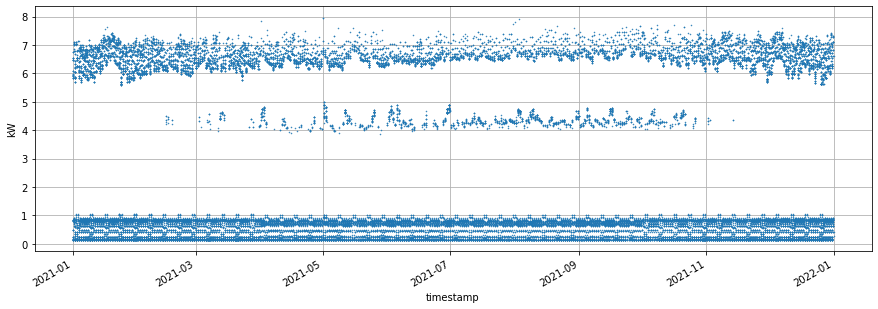

In [10]:
import pandas, datetime
def to_timestamp(s):
    return datetime.datetime.fromisoformat(s)
def to_real(s):
    return complex(s).real
panel = pandas.read_csv('house_1.csv',
                        converters = {
                            'timestamp':to_timestamp,
                            'panel.energy':to_real,
                            'panel.power':to_real,
                            'panel.constant_power':to_real,
                            'panel.constant_current':to_real,
                            'panel.constant_admittance':to_real,
                        },
                        index_col='timestamp')
panel['panel.power'].plot(style='.',markersize=1,figsize=(15,5),ylabel='kW',grid=True)